Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 6, 2020  

---
## Part 2 - Belousov-Zhabotinsky data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wd = "/mnt/Backups/jmhu"
data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"

### Load data

### Question 1. Download data

In [4]:
if not os.path.exists(data_dir + "BZ.mat"):
    print("Download data")
    !wget -P $data_dir courses.washington.edu/amath582/BZ.mat 
else:
    print("Data downloaded")

Data downloaded


In [5]:
f = h5py.File(data_dir + 'BZ.mat','r')
data = f.get('BZ_tensor')
data = np.array(data)
data.shape

(1200, 451, 351)

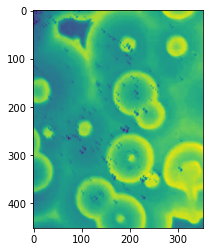

In [6]:
plt.imshow(data[0])

In [7]:
# Subset a quarter of the data: since this is a video, frames are sequential and order matters. 
data_subset = data[::4, :, :]
data_subset.shape

(300, 451, 351)

In [8]:
import matplotlib.animation as animation
fig = plt.figure()

# Create list of image frames
ims = []
for frame in data_subset:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

# Create animation artist using figure instance and frame list    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1e5)

# Don't show the figure
plt.close(ani._fig)

# Call function to display the animation
from IPython.display import HTML
HTML(ani.to_html5_video())

# Save as mp4
# ani.save('dynamic_images.mp4')

### DMD and time-delay DMD model with forecasts, determine if any latent variables with Hankel matrix

#### Define functions

In [9]:
def DMD(X, Xprime, r, dt=2):
    '''Dynamic Mode Decomposition Function from book'''
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    Omega = np.log(np.diag(Lambda))/dt
    return Phi, Omega, b, Lambda

def forecast(Phi, Omega, t, b, r, dt):
    u_modes = np.zeros((r, t))
    time_vector = dt*np.arange(-1, t-1)
    
    for i in np.arange(0, t):
        u_modes[:, i]=b * np.exp(Omega * time_vector[i])

    Xdmd = Phi @ u_modes
    print(t, u_modes.shape, time_vector.shape, Xdmd.shape)
    return(Xdmd)

#### Subset data

In [10]:
# Subset a quarter of the data and reshape for DMD, with each pixel as a state variable
data_subset = data[::4, :, :]
print(data_subset.shape)

data_subset = np.reshape(data_subset, (data_subset.shape[0], data_subset.shape[1]*data_subset.shape[2]))
print(data_subset.shape)

(300, 451, 351)
(300, 158301)


In [11]:
# Data reshaping checks
data_subset_reshaped = np.reshape(data_subset, 
                                  (data_subset.shape[0], 451, 351))

# Try reshaping the data back to original form
print(data_subset_reshaped.shape)

# Check that everything is back where it should be
np.all(data[::4, :, :] == data_subset_reshaped)

(300, 451, 351)


True

#### Set-up matrices

In [12]:
# Take two snapshots of the system encompassing the entire subsetted time series
X = data_subset[:-1, :]
Xprime = data_subset[1:, :]
print(X.shape, Xprime.shape)

# Transpose matrices - observations (states) first, time step second
X=X.T
Xprime=Xprime.T
print(X.shape, Xprime.shape)

(299, 158301) (299, 158301)
(158301, 299) (158301, 299)


#### Run DMD

In [13]:
%%time

# DMD it
t=X.shape[1]
dt=4 # Since you subset every fourth frame
r=10

Phi, Omega, b, Lambda = DMD(X, Xprime, r)

print(" Phi : Omega : b ", )
print(Phi.shape, Omega.shape, b.shape)

 Phi : Omega : b 
(158301, 10) (10,) (10,)
CPU times: user 1min 4s, sys: 2.48 s, total: 1min 6s
Wall time: 3.76 s


#### Use DMD components to forecast

In [14]:
%%time
Xdmd = forecast(Phi, Omega, t, b, r, dt)

<ipython-input-9-ba541dc306c4>:22: ComplexWarning: Casting complex values to real discards the imaginary part
  u_modes[:, i]=b * np.exp(Omega * time_vector[i])


299 (10, 299) (299,) (158301, 299)
CPU times: user 2.73 s, sys: 11.4 s, total: 14.2 s
Wall time: 714 ms


In [15]:
fontsize=16
weight='bold'

#### Plot reconstruction of some random pixels

In [16]:
hs=[157395, 34319, 146330, 17027, 107323]

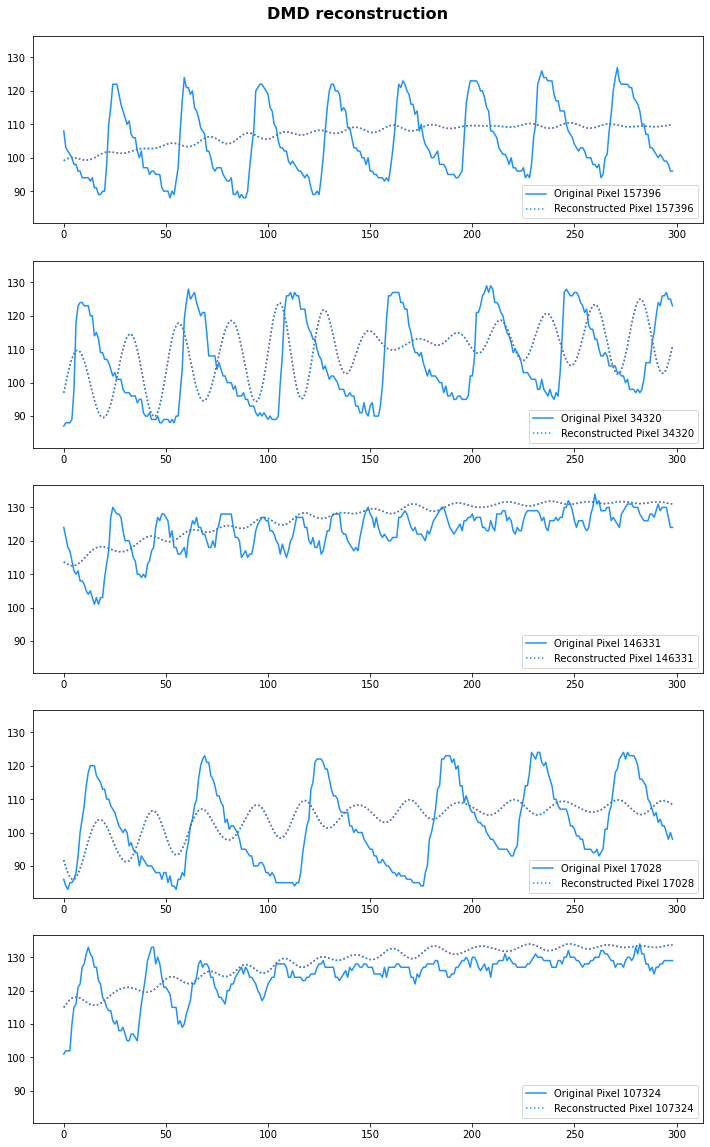

In [17]:
fig, axes = plt.subplots(len(hs), 1, figsize=(12, 4*len(hs)), sharey=True)

for i, ax in enumerate(axes):
    h = hs[i]
#     h=np.random.randint(0, Phi.shape[0], size=1)
    labels=["Pixel " + str(h+1)]

    ax.plot(X.T[:,h], color="dodgerblue", label=str("Original " + labels[0]))
    ax.plot(np.real(Xdmd.T[:,h]), color="firebrick", linestyle=":")
    ax.plot(np.real(Xdmd.T[:,h]), color="dodgerblue", linestyle=":", label="Reconstructed " + labels[0])
    ax.legend(loc="lower right");

plt.suptitle("DMD reconstruction", fontsize=fontsize, weight=weight, y=0.9);

#### Visualize reconstructions in 2d

In [18]:
# Reshape
Xdmd_movie = np.reshape(Xdmd.T, 
                        (Xdmd.T[:, 0].shape[0], data.shape[1], data.shape[2]))

# Take only the real components
Xdmd_movie = np.real(Xdmd_movie)

print("DMD shape:", Xdmd.T.shape)
print("Reshaped:", Xdmd_movie.shape)

# Check first frame shape
Xdmd_movie[0].shape

DMD shape: (299, 158301)
Reshaped: (299, 451, 351)


(451, 351)

#### Compare the two

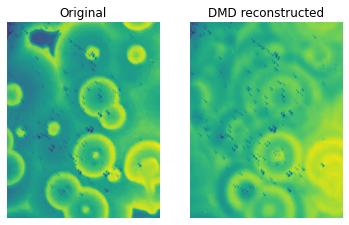

In [19]:
fig, ax = plt.subplots(1, 2)#, figsize=())
ax[1].imshow(Xdmd_movie[0])
ax[0].imshow(data[0])
ax[1].set_title("DMD reconstructed")
ax[0].set_title("Original");
ax[0].axis('off');
ax[1].axis('off');

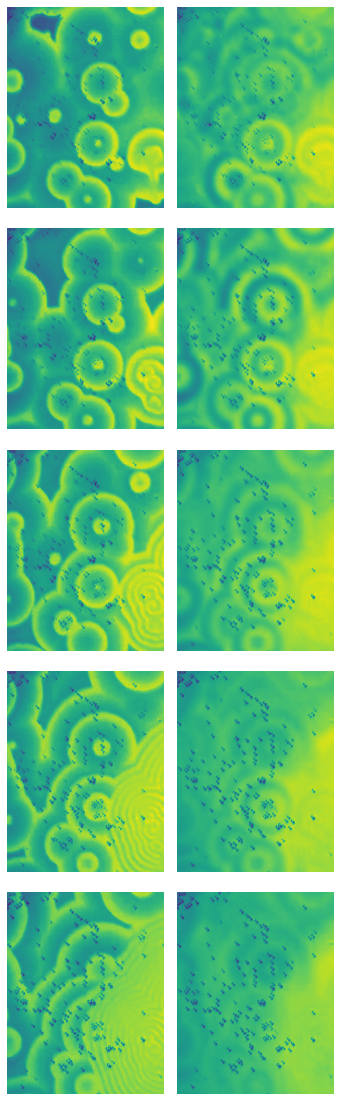

In [20]:
fig, ax = plt.subplots(5, 2, figsize=(6, 20))

frames = [0, 38, 100, 187, 298]

for i, j in enumerate(ax):
    frame = frames[i]
    ax[i, 0].imshow(data[frame*4])
#     ax[i, 0].text(x=10, y=50, s="Original frame " + str(frame*4), color='w', size=14, weight='semibold')
    ax[i, 0].axis('off');

    ax[i, 1].imshow(Xdmd_movie[frame])
#     ax[i, 1].text(x=10, y=50, s="DMD reconstructed", color='w', size=14, weight='semibold')
    ax[i, 1].axis('off');
plt.subplots_adjust(wspace=0.03, hspace=0.1)

#### Check out the movie version

In [21]:
fig = plt.figure()

# Create list of image frames
ims = []
for frame in Xdmd_movie:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

# Create animation artist using figure instance and frame list    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1e5)

# Don't show the figure
plt.close(ani._fig)

# Call function to display the animation
from IPython.display import HTML
HTML(ani.to_html5_video())

#### And forecast

In [22]:
t_forecast = t*2
Xdmd_forecast = forecast(Phi, Omega, t_forecast, b, r, dt)

<ipython-input-9-ba541dc306c4>:22: ComplexWarning: Casting complex values to real discards the imaginary part
  u_modes[:, i]=b * np.exp(Omega * time_vector[i])


598 (10, 598) (598,) (158301, 598)


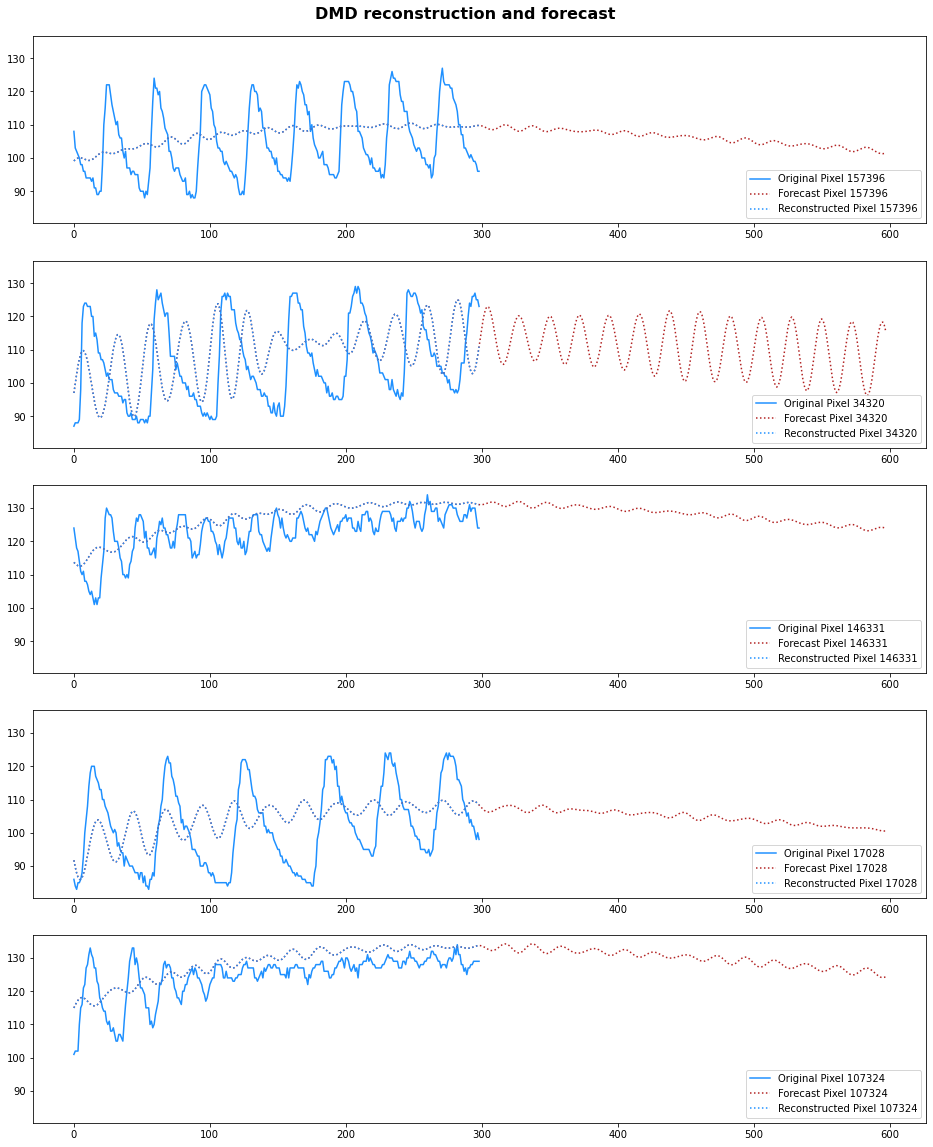

In [23]:
fig, axes = plt.subplots(len(hs), 1, figsize=(16, 4*len(hs)), sharey=True)

for i, ax in enumerate(axes):
#     h=np.random.randint(0, Phi.shape[0], size=1)
    h=hs[i]
    labels=["Pixel " + str(h+1)]

    ax.plot(X.T[:,h], "dodgerblue", label=str("Original " + labels[0]))
    ax.plot(np.real(Xdmd_forecast.T[:,h]), color="firebrick", linestyle=":", label="Forecast " + labels[0])
    ax.plot(np.real(Xdmd.T[:,h]), color="dodgerblue", linestyle=":", label="Reconstructed " + labels[0])
    ax.legend(loc="lower right");

plt.suptitle("DMD reconstruction and forecast", fontsize=fontsize, weight=weight, y=0.9);

#### Reshape and plot 2d visualization

DMD shape: (299, 158301)
Reshaped: (598, 451, 351)


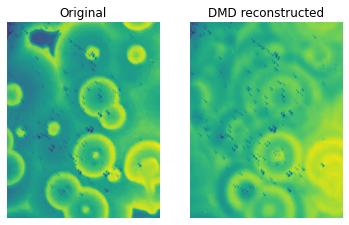

In [24]:
# Reshape
Xdmd_movie_forecast = np.reshape(Xdmd_forecast.T, 
                                 (Xdmd_forecast.T[:, 0].shape[0], data.shape[1], data.shape[2]))

# Take only the real components
Xdmd_movie_forecast = np.real(Xdmd_movie_forecast)

print("DMD shape:", Xdmd.T.shape)
print("Reshaped:", Xdmd_movie_forecast.shape)

fig, ax = plt.subplots(1, 2)#, figsize=())
ax[1].imshow(Xdmd_movie_forecast[0])
ax[0].imshow(data[0])
ax[1].set_title("DMD reconstructed")
ax[0].set_title("Original");
ax[0].axis('off');
ax[1].axis('off');

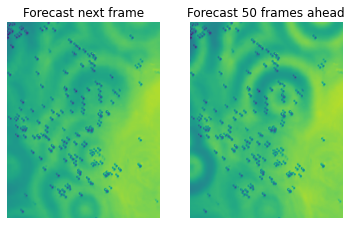

In [25]:
fig, ax = plt.subplots(1, 2)#, figsize=())
ax[0].imshow(Xdmd_movie_forecast[len(data_subset)+1])
ax[1].imshow(Xdmd_movie_forecast[len(data_subset)+50])
ax[0].set_title("Forecast next frame")
ax[1].set_title("Forecast 50 frames ahead");
ax[0].axis('off');
ax[1].axis('off');

#### Visualize the forecast video

In [26]:
fig = plt.figure()

# Create list of image frames
ims = []
for frame in Xdmd_movie_forecast:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

# Create animation artist using figure instance and frame list    
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1e5)

# Don't show the figure
plt.close(ani._fig)

# Call function to display the animation
from IPython.display import HTML
HTML(ani.to_html5_video())